# First contact with the dataset
This Notebook has as objective to replicate the baseline results from Minixhofer et al. (2021)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler
import torch.nn.functional as F
from sklearn.metrics import f1_score, mean_absolute_error

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter



**Note :** Just to have a normalized methodology to save and visualize the results of all the experiments trought this projet I add and configure a Tensorboard-SummaryWriter. In the same way I have changed the training cycle to put the results in the tensorboard format.

In [2]:
writer = SummaryWriter('../runs/LSTM_attention_emb')

## Importing the data in a unique dictionary

In [3]:
filesList = os.listdir('../src')
print(filesList)

['soil_data.csv', 'train_timeseries', 'counties.geojson', 'test_timeseries', 'validation_timeseries', 'counties.zip']


In [4]:
dataDic = {"train": pd.read_csv("../src/train_timeseries/train_timeseries.csv"),
           "test": pd.read_csv("../src/test_timeseries/test_timeseries.csv"),
           "validation": pd.read_csv("../src/validation_timeseries/validation_timeseries.csv"),
           "soil" : pd.read_csv("../src/soil_data.csv"),
           }


In [5]:
dataDic["train"].columns

Index(['fips', 'date', 'PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET',
       'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX',
       'WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN',
       'WS50M_RANGE', 'score'],
      dtype='object')

In [6]:
class2id = {
    'None': 0,
    'D0': 1,
    'D1': 2,
    'D2': 3,
    'D3': 4,
    'D4': 5,
}
id2class = {v: k for k, v in class2id.items()}

In [7]:
dfs = {
    k: dataDic[k].set_index(['fips', 'date'])
    for k in dataDic.keys() if k != "soil"
}

dfs["soil"] = dataDic["soil"]

In [8]:
# dfs["train"]

## Interpolation pour les données manquantes

In [9]:
def interpolate_nans(padata, pkind='linear'):
    """
    see: https://stackoverflow.com/a/53050216/2167159
    """
    aindexes = np.arange(padata.shape[0])
    agood_indexes, = np.where(np.isfinite(padata))
    f = interp1d(agood_indexes
               , padata[agood_indexes]
               , bounds_error=False
               , copy=False
               , fill_value="extrapolate"
               , kind=pkind)
    return f(aindexes)

## Function to encode the cycling feature: year-day, using sin/cos

In [10]:
def date_encode(date):
    if isinstance(date, str):
        date = datetime.strptime(date, "%Y-%m-%d")
    return (
        np.sin(2 * np.pi * date.timetuple().tm_yday / 366),
        np.cos(2 * np.pi * date.timetuple().tm_yday / 366),
    )

## Function to load the data

In [11]:
def loadXY(
    df,
    random_state=42,
    window_size=180, # how many days in the past (default/competition: 180)
    target_size=6, # how many weeks into the future (default/competition: 6)
    fuse_past=True, # add the past drought observations? (default: True)
    return_fips=False, # return the county identifier (do not use for predictions)
    encode_season=True, # encode the season using the function above (default: True) 
    use_prev_year=False, # add observations from 1 year prior?
):
    df = dfs[df]
    soil_df = dfs["soil"]
    time_data_cols = sorted(
        [c for c in df.columns if c not in ["fips", "date", "score"]]
    )
    static_data_cols = sorted(
        [c for c in soil_df.columns if c not in ["soil", "lat", "lon"]]
    )
    count = 0
    score_df = df.dropna(subset=["score"])
    X_static = np.empty((len(df) // window_size, len(static_data_cols)))
    X_fips_date = []
    add_dim = 0
    if use_prev_year:
        add_dim += len(time_data_cols)
    if fuse_past:
        add_dim += 1
        if use_prev_year:
            add_dim += 1
    if encode_season:
        add_dim += 2
    X_time = np.empty(
        (len(df) // window_size, window_size, len(time_data_cols) + add_dim)
    )
    y_past = np.empty((len(df) // window_size, window_size))
    y_target = np.empty((len(df) // window_size, target_size))
    if random_state is not None:
        np.random.seed(random_state)
    for fips in tqdm(score_df.index.get_level_values(0).unique()):
        if random_state is not None:
            start_i = np.random.randint(1, window_size)
        else:
            start_i = 1
        fips_df = df[(df.index.get_level_values(0) == fips)]
        X = fips_df[time_data_cols].values
        y = fips_df["score"].values
        X_s = soil_df[soil_df["fips"] == fips][static_data_cols].values[0]
        for i in range(start_i, len(y) - (window_size + target_size * 7), window_size):
            X_fips_date.append((fips, fips_df.index[i : i + window_size][-1]))
            X_time[count, :, : len(time_data_cols)] = X[i : i + window_size]
            if use_prev_year:
                if i < 365 or len(X[i - 365 : i + window_size - 365]) < window_size:
                    continue
                X_time[count, :, -len(time_data_cols) :] = X[
                    i - 365 : i + window_size - 365
                ]
            if not fuse_past:
                y_past[count] = interpolate_nans(y[i : i + window_size])
            else:
                X_time[count, :, len(time_data_cols)] = interpolate_nans(
                    y[i : i + window_size]
                )
            if encode_season:
                enc_dates = [
                    date_encode(d) for f, d in fips_df.index[i : i + window_size].values
                ]
                d_sin, d_cos = [s for s, c in enc_dates], [c for s, c in enc_dates]
                X_time[count, :, len(time_data_cols) + (add_dim - 2)] = d_sin
                X_time[count, :, len(time_data_cols) + (add_dim - 2) + 1] = d_cos
            temp_y = y[i + window_size : i + window_size + target_size * 7]
            y_target[count] = np.array(temp_y[~np.isnan(temp_y)][:target_size])
            X_static[count] = X_s
            count += 1
    print(f"loaded {count} samples")
    results = [X_static[:count], X_time[:count], y_target[:count]]
    if not fuse_past:
        results.append(y_past[:count])
    if return_fips:
        results.append(X_fips_date)
    return results

In [12]:
scaler_dict = {}
scaler_dict_static = {}
scaler_dict_past = {}


def normalize(X_static, X_time, y_past=None, fit=False):
    for index in tqdm(range(X_time.shape[-1])):
        if fit:
            scaler_dict[index] = RobustScaler().fit(X_time[:, :, index].reshape(-1, 1))
        X_time[:, :, index] = (
            scaler_dict[index]
            .transform(X_time[:, :, index].reshape(-1, 1))
            .reshape(-1, X_time.shape[-2])
        )
    for index in tqdm(range(X_static.shape[-1])):
        if fit:
            scaler_dict_static[index] = RobustScaler().fit(
                X_static[:, index].reshape(-1, 1)
            )
        X_static[:, index] = (
            scaler_dict_static[index]
            .transform(X_static[:, index].reshape(-1, 1))
            .reshape(1, -1)
        )
    index = 0
    if y_past is not None:
        if fit:
            scaler_dict_past[index] = RobustScaler().fit(y_past.reshape(-1, 1))
        y_past[:, :] = (
            scaler_dict_past[index]
            .transform(y_past.reshape(-1, 1))
            .reshape(-1, y_past.shape[-1])
        )
        return X_static, X_time, y_past
    return X_static, X_time

In [13]:
# X_tabular_train, X_time_train, y_target_train = loadXY("train", use_prev_year=True)
# print("train shape", X_time_train.shape)
# X_tabular_validation, X_time_valid, y_target_valid, valid_fips = loadXY("validation", return_fips=True, use_prev_year=True)
# print("validation shape", X_time_valid.shape)
# X_tabular_test, X_time_test, y_target_test, test_fips = loadXY("test", return_fips=True, use_prev_year=True)
# print("test shape", X_time_test.shape)
# X_tabular_train, X_time_train = normalize(X_tabular_train, X_time_train, fit=True)
# X_tabular_validation, X_time_valid = normalize(X_tabular_validation, X_time_valid)
# X_tabular_test, X_time_test = normalize(X_tabular_test, X_time_test)

In [14]:
# # export all
# import pickle
# np.save("../data/processed_no_cat_and_no_tensors/X_tabular_train.npy", X_tabular_train)
# np.save("../data/processed_no_cat_and_no_tensors/X_time_train.npy", X_time_train)
# np.save("../data/processed_no_cat_and_no_tensors/y_target_train.npy", y_target_train)
# np.save("../data/processed_no_cat_and_no_tensors/X_tabular_validation.npy", X_tabular_validation)
# np.save("../data/processed_no_cat_and_no_tensors/X_time_valid.npy", X_time_valid)
# np.save("../data/processed_no_cat_and_no_tensors/y_target_valid.npy", y_target_valid)
# np.save("../data/processed_no_cat_and_no_tensors/X_tabular_test.npy", X_tabular_test)
# np.save("../data/processed_no_cat_and_no_tensors/X_time_test.npy", X_time_test)
# np.save("../data/processed_no_cat_and_no_tensors/y_target_test.npy", y_target_test)
# with open(f"../data/processed_no_cat_and_no_tensors/valid_fips.pickle", "wb") as f:
#     pickle.dump(valid_fips, f)
# with open(f"../data/processed_no_cat_and_no_tensors/test_fips.pickle", "wb") as f:
#     pickle.dump(test_fips, f)

In [15]:
# # import all
# import pickle
# # import all
# X_tabular_train = np.load("../data/processed_no_cat_and_no_tensors/X_tabular_train.npy")
# X_time_train = np.load("../data/processed_no_cat_and_no_tensors/X_time_train.npy")
# y_target_train = np.load("../data/processed_no_cat_and_no_tensors/y_target_train.npy")
# X_tabular_validation = np.load("../data/processed_no_cat_and_no_tensors/X_tabular_validation.npy")
# X_time_valid = np.load("../data/processed_no_cat_and_no_tensors/X_time_valid.npy")
# y_target_valid = np.load("../data/processed_no_cat_and_no_tensors/y_target_valid.npy")
# X_tabular_test = np.load("../data/processed_no_cat_and_no_tensors/X_tabular_test.npy")
# X_time_test = np.load("../data/processed_no_cat_and_no_tensors/X_time_test.npy")
# y_target_test = np.load("../data/processed_no_cat_and_no_tensors/y_target_test.npy")
# with open(f"../data/processed_no_cat_and_no_tensors/valid_fips.pickle", "rb") as f:
#     valid_fips = pickle.load(f)
# with open(f"../data/processed_no_cat_and_no_tensors/test_fips.pickle", "rb") as f:
#     test_fips = pickle.load(f)


In [16]:
batch_size = 128
output_weeks = 6
use_static = True
hidden_dim = 512
n_layers = 2
ffnn_layers = 2
dropout = 0.1
one_cycle = True
lr = 7e-5
epochs = 10
clip = 5

In [17]:
# import
import pickle
with open("../data/data.pkl", "rb") as f:
    data = pickle.load(f)
    X_tabular_train = data["X_tabular_train"]
    X_time_train = data["X_time_train"]
    y_target_train = data["y_target_train"]
    X_tabular_validation = data["X_tabular_validation"]
    X_time_valid = data["X_time_valid"]
    y_target_valid = data["y_target_valid"]
    valid_fips = data["valid_fips"]
    X_tabular_test = data["X_tabular_test"]
    X_time_test = data["X_time_test"]
    y_target_test = data["y_target_test"]
    test_fips = data["test_fips"]


In [18]:
X_tabular_train.shape

(97099, 30)

In [19]:
X_time_train.shape

(97099, 180, 40)

In [20]:
ordered_cols = sorted([c for c in dfs["soil"].columns if c not in ["soil", "lat", "lon"]])

In [21]:
cat_cols = [ordered_cols.index(i) for i in ["fips"]]

In [22]:
cat_cols

[21]

In [23]:
X_tabular_cat_train = X_tabular_train[:,cat_cols].astype(int)
X_tabular_train = X_tabular_train[:,[i for i in range(X_tabular_train.shape[1]) if i not in cat_cols]]

X_tabular_cat_valid = X_tabular_validation[:,cat_cols].astype(int)
X_tabular_validation = X_tabular_validation[:,[i for i in range(X_tabular_validation.shape[1]) if i not in cat_cols]]

X_tabular_cat_test = X_tabular_test[:,cat_cols].astype(int)
X_tabular_test = X_tabular_test[:,[i for i in range(X_tabular_test.shape[1]) if i not in cat_cols]]

In [24]:
dico_trad = {}
for cat in range(X_tabular_cat_train.shape[1]):
    dico_trad[cat] = {j: i for i,j in enumerate(sorted(np.unique_values(X_tabular_cat_train[:,cat])))}
    dico_trad[cat]["unknown"] = len(np.unique_values(X_tabular_cat_train[:,cat]))

In [25]:
dico_trad[0]

{np.int64(1001): 0,
 np.int64(1003): 1,
 np.int64(1005): 2,
 np.int64(1007): 3,
 np.int64(1009): 4,
 np.int64(1011): 5,
 np.int64(1013): 6,
 np.int64(1015): 7,
 np.int64(1017): 8,
 np.int64(1019): 9,
 np.int64(1021): 10,
 np.int64(1023): 11,
 np.int64(1025): 12,
 np.int64(1027): 13,
 np.int64(1029): 14,
 np.int64(1031): 15,
 np.int64(1033): 16,
 np.int64(1035): 17,
 np.int64(1037): 18,
 np.int64(1039): 19,
 np.int64(1041): 20,
 np.int64(1043): 21,
 np.int64(1045): 22,
 np.int64(1047): 23,
 np.int64(1049): 24,
 np.int64(1051): 25,
 np.int64(1053): 26,
 np.int64(1055): 27,
 np.int64(1057): 28,
 np.int64(1059): 29,
 np.int64(1061): 30,
 np.int64(1063): 31,
 np.int64(1065): 32,
 np.int64(1067): 33,
 np.int64(1069): 34,
 np.int64(1071): 35,
 np.int64(1073): 36,
 np.int64(1075): 37,
 np.int64(1077): 38,
 np.int64(1079): 39,
 np.int64(1081): 40,
 np.int64(1083): 41,
 np.int64(1085): 42,
 np.int64(1087): 43,
 np.int64(1089): 44,
 np.int64(1091): 45,
 np.int64(1093): 46,
 np.int64(1095): 47,
 n

In [26]:
for cat in range(len(cat_cols)):
    X_tabular_cat_train[:,cat] = [dico_trad[cat][i] for i in X_tabular_cat_train[:,cat]]
    X_tabular_cat_valid[:,cat] = [dico_trad[cat][i] if i in dico_trad[cat] else dico_trad[cat]["unknown"] for i in X_tabular_cat_valid[:,cat]]
    X_tabular_cat_test[:,cat] = [dico_trad[cat][i] if i in dico_trad[cat] else dico_trad[cat]["unknown"] for i in X_tabular_cat_test[:,cat]]

In [27]:
np.unique(X_tabular_cat_train[:,0])

array([   0,    1,    2, ..., 3105, 3106, 3107])

In [28]:
X_tabular_train, X_time_train = normalize(X_tabular_train, X_time_train, fit=True)
X_tabular_validation, X_time_valid = normalize(X_tabular_validation, X_time_valid)
X_tabular_test, X_time_test = normalize(X_tabular_test, X_time_test)

100%|██████████| 29/29 [00:00<00:00, 11035.64it/s]


In [29]:
#  Prepare the datasets
train_data = TensorDataset(
    torch.tensor(X_time_train),
    torch.tensor(X_tabular_train),
    torch.tensor(X_tabular_cat_train),
    torch.tensor(y_target_train[:, :output_weeks]),
)
valid_data = TensorDataset(
    torch.tensor(X_time_valid),
    torch.tensor(X_tabular_validation),
    torch.tensor(X_tabular_cat_valid),
    torch.tensor(y_target_valid[:, :output_weeks]),
)

# DataLoaders with sampler for training and default for validation
train_loader = DataLoader(
    train_data, batch_size=batch_size, drop_last=False
)

valid_loader = DataLoader(
    valid_data, shuffle=False, batch_size=batch_size, drop_last=False
)

test_data = TensorDataset(
    torch.tensor(X_time_test),
    torch.tensor(X_tabular_test),
    torch.tensor(X_tabular_cat_test),
    torch.tensor(y_target_test[:, :output_weeks]),
)

test_loader = DataLoader(
    test_data, shuffle=False, batch_size=batch_size, drop_last=False
)

In [30]:
next(iter(test_loader))[2].shape

torch.Size([128, 1])

In [31]:
my_dataset = torch.utils.data.ConcatDataset([valid_data, test_data])
my_loader = DataLoader(my_dataset, shuffle=False, batch_size=batch_size, drop_last=False)

In [32]:
list_cat = [len(np.unique(X_tabular_cat_train[:,i])) + 1 for i in range(X_tabular_cat_train.shape[1])]

In [33]:
class DroughtNetLSTM(nn.Module):
    def __init__(
        self,
        output_size,
        num_input_features,
        hidden_dim,
        n_layers,
        ffnn_layers,
        drop_prob,
        static_dim,
        list_unic_cat,
        embedding_dims,
    ):
        super(DroughtNetLSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embeddings = nn.ModuleList(
                [
                    nn.Embedding(num_embeddings=i, embedding_dim=dimension)
                    for i, dimension in zip(list_unic_cat, embedding_dims)
                ]
            )
        
        self.lstm = nn.LSTM(
            num_input_features,
            hidden_dim,
            n_layers,
            dropout=drop_prob,
            batch_first=True,
        )
        self.attention = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(drop_prob)
        self.fflayers = []
        for i in range(ffnn_layers - 1): #TODO OJO, Hecho con las patas. Pin pan pun, hace sus movidas y retorna no se que
            if i == 0:
                self.fflayers.append(nn.Linear(hidden_dim*2 + static_dim + sum(embedding_dims), hidden_dim))
            else:
                self.fflayers.append(nn.Linear(hidden_dim*2, hidden_dim))
        self.fflayers = nn.ModuleList(self.fflayers)
        self.final = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden, static=None, cat=None):
        batch_size = x.size(0)
        x = x.to(dtype=torch.float32)
        if static is not None:
            static = static.to(dtype=torch.float32)
        lstm_out, hidden = self.lstm(x, hidden)
        last_hidden = lstm_out[:, -1, :]
        attn_weights = F.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.sum(attn_weights * lstm_out, dim=1)
        att_out = torch.cat((context_vector, last_hidden), 1)
        out = self.dropout(att_out)

        embeddings = [emb(cat[:, i]) for i, emb in enumerate(self.embeddings)]
        cat = torch.cat(embeddings, dim=1)

        for i in range(len(self.fflayers)):
            if i == 0 and static is not None:
                out = self.fflayers[i](torch.cat((out, static, cat), 1))
            else:
                out = self.fflayers[i](out)
        out = self.final(out)

        out = out.view(batch_size, -1)
        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
        )
        return hidden

In [34]:
static_dim = X_tabular_train.shape[-1]

In [35]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("using GPU")
else:
    device = torch.device("cpu")
    print("using CPU")
static_dim = 0
if use_static:
    static_dim = X_tabular_train.shape[-1]
model = DroughtNetLSTM(
    output_weeks,
    X_time_train.shape[-1],
    hidden_dim,
    n_layers,
    ffnn_layers,
    dropout,
    static_dim,
    list_unic_cat=list_cat,
    embedding_dims=[570],
)
model.to(device)
loss_function = nn.MSELoss()
if one_cycle:
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs
    )
else:
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
counter = 0
valid_loss_min = np.inf
torch.manual_seed(42)
np.random.seed(42)
for i in range(epochs):
    h = model.init_hidden(batch_size)

    for k, (inputs, static, cat , labels) in tqdm(
        enumerate(train_loader),
        desc=f"epoch {i+1}/{epochs}",
        total=len(train_loader),
    ):
        model.train()
        counter += 1
        if len(inputs) < batch_size:
            h = model.init_hidden(len(inputs))
        h = tuple([e.data for e in h])
        inputs, labels, static, cat = (
            inputs.to(device),
            labels.to(device),
            static.to(device),
            cat.to(device),
        )
        model.zero_grad()
        if use_static:
            output, h = model(inputs, h, static, cat)
        else:
            output, h = model(inputs, h)
        loss = loss_function(output, labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        if one_cycle:
            scheduler.step()

        with torch.no_grad():
            if k == len(train_loader) - 1 or k == (len(train_loader) - 1) // 2:
                val_h = model.init_hidden(batch_size)
                val_losses = []
                model.eval()
                labels = []
                preds = []
                raw_labels = []
                raw_preds = []
                for inp, stat, catego, lab in test_loader:
                    if len(inp) < batch_size:
                        val_h = model.init_hidden(len(inp))
                    val_h = tuple([each.data for each in val_h])
                    inp, lab, stat, catego = inp.to(device), lab.to(device), stat.to(device), catego.to(device)
                    if use_static:
                        out, val_h = model(inp, val_h, stat, catego)
                    else:
                        out, val_h = model(inp, val_h)
                    val_loss = loss_function(out, lab.float())
                    val_losses.append(val_loss.item())
                    for labs in lab:
                        labels.append([int(l.round()) for l in labs])
                        raw_labels.append([float(l) for l in labs])
                    for pred in out:
                        preds.append([int(p.round()) for p in pred])
                        raw_preds.append([float(p) for p in pred])
                # log data
                labels = np.array(labels)
                preds = np.clip(np.array(preds), 0, 5)
                raw_preds = np.array(raw_preds)
                raw_labels = np.array(raw_labels)
                for i in range(output_weeks):
                    log_dict = {
                        "loss": float(loss),
                        "epoch": counter / len(train_loader),
                        "step": counter,
                        "lr": optimizer.param_groups[0]["lr"],
                        "week": i + 1,
                    }
                    # w = f'week_{i+1}_'
                    w = ""
                    log_dict[f"{w}validation_loss"] = np.mean(val_losses)
                    log_dict[f"{w}macro_f1"] = f1_score(
                        labels[:, i], preds[:, i], average="macro"
                    )
                    log_dict[f"{w}micro_f1"] = f1_score(
                        labels[:, i], preds[:, i], average="micro"
                    )
                    log_dict[f"{w}mae"] = mean_absolute_error(
                        raw_labels[:, i], raw_preds[:, i]
                    )
                    print(log_dict)
                    writer.add_scalars("Loss(MSE)", {'train': loss,
                                                     'validation': log_dict[f"{w}validation_loss"]},
                                                     counter)
                    writer.add_scalars("F1(MSE)", {'macro': log_dict[f"{w}macro_f1"],
                                                   'micro': log_dict[f"{w}micro_f1"]},
                                                   counter)
                    writer.add_scalar("MAE", log_dict[f"{w}mae"],
                                      counter)
                    writer.add_scalar("Learning-Rate", log_dict["lr"],
                                      counter)
                    for j, f1 in enumerate(
                        f1_score(labels[:, i], preds[:, i], average=None)
                    ):
                        log_dict[f"{w}{id2class[j]}_f1"] = f1
                    model.train()
                if np.mean(val_losses) <= valid_loss_min:
                    torch.save(model.state_dict(), "../models/LSTM_attention_emb.pt")
                    print(
                        "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                            valid_loss_min, np.mean(val_losses)
                        )
                    )
                    valid_loss_min = np.mean(val_losses)

using GPU


epoch 1/10:  50%|█████     | 380/759 [02:15<09:22,  1.48s/it]

{'loss': 0.6730238795280457, 'epoch': 0.5006587615283268, 'step': 380, 'lr': 7.317018257621514e-06, 'week': 1, 'validation_loss': np.float64(0.9459134325385093), 'macro_f1': np.float64(0.14776916271879462), 'micro_f1': np.float64(0.2886556318126766), 'mae': np.float64(0.7496545607587324)}
{'loss': 0.6730238795280457, 'epoch': 0.5006587615283268, 'step': 380, 'lr': 7.317018257621514e-06, 'week': 2, 'validation_loss': np.float64(0.9459134325385093), 'macro_f1': np.float64(0.1345167696975068), 'micro_f1': np.float64(0.2854259184497376), 'mae': np.float64(0.7610387505777165)}
{'loss': 0.6730238795280457, 'epoch': 0.5006587615283268, 'step': 380, 'lr': 7.317018257621514e-06, 'week': 3, 'validation_loss': np.float64(0.9459134325385093), 'macro_f1': np.float64(0.13729518690859147), 'micro_f1': np.float64(0.29228905934598304), 'mae': np.float64(0.7920536977753772)}
{'loss': 0.6730238795280457, 'epoch': 0.5006587615283268, 'step': 380, 'lr': 7.317018257621514e-06, 'week': 4, 'validation_loss': 

epoch 1/10: 100%|██████████| 759/759 [04:32<00:00,  2.79it/s]


{'loss': 0.24593709409236908, 'epoch': 1.0, 'step': 759, 'lr': 1.9613390103485664e-05, 'week': 1, 'validation_loss': np.float64(0.28832377791404723), 'macro_f1': np.float64(0.6460039796921613), 'micro_f1': np.float64(0.7932983447719015), 'mae': np.float64(0.28817140322593154)}
{'loss': 0.24593709409236908, 'epoch': 1.0, 'step': 759, 'lr': 1.9613390103485664e-05, 'week': 2, 'validation_loss': np.float64(0.28832377791404723), 'macro_f1': np.float64(0.5757704157872303), 'micro_f1': np.float64(0.7178037949132015), 'mae': np.float64(0.3468877220871483)}
{'loss': 0.24593709409236908, 'epoch': 1.0, 'step': 759, 'lr': 1.9613390103485664e-05, 'week': 3, 'validation_loss': np.float64(0.28832377791404723), 'macro_f1': np.float64(0.5043196875882238), 'micro_f1': np.float64(0.7040775131207105), 'mae': np.float64(0.3783665411286107)}
{'loss': 0.24593709409236908, 'epoch': 1.0, 'step': 759, 'lr': 1.9613390103485664e-05, 'week': 4, 'validation_loss': np.float64(0.28832377791404723), 'macro_f1': np.flo

epoch 2/10:  50%|█████     | 380/759 [02:17<09:27,  1.50s/it]

{'loss': 0.2588610053062439, 'epoch': 1.5006587615283267, 'step': 1139, 'lr': 3.644637850599361e-05, 'week': 1, 'validation_loss': np.float64(0.2856185004115105), 'macro_f1': np.float64(0.6670079459926871), 'micro_f1': np.float64(0.8255954784012919), 'mae': np.float64(0.259986292946376)}
{'loss': 0.2588610053062439, 'epoch': 1.5006587615283267, 'step': 1139, 'lr': 3.644637850599361e-05, 'week': 2, 'validation_loss': np.float64(0.2856185004115105), 'macro_f1': np.float64(0.5591415386016263), 'micro_f1': np.float64(0.7452563584981833), 'mae': np.float64(0.32155645542119266)}
{'loss': 0.2588610053062439, 'epoch': 1.5006587615283267, 'step': 1139, 'lr': 3.644637850599361e-05, 'week': 3, 'validation_loss': np.float64(0.2856185004115105), 'macro_f1': np.float64(0.4618331529717677), 'micro_f1': np.float64(0.7048849414614453), 'mae': np.float64(0.37093595280401953)}
{'loss': 0.2588610053062439, 'epoch': 1.5006587615283267, 'step': 1139, 'lr': 3.644637850599361e-05, 'week': 4, 'validation_loss'

epoch 2/10: 100%|██████████| 759/759 [04:34<00:00,  2.76it/s]


{'loss': 0.17089752852916718, 'epoch': 2.0, 'step': 1518, 'lr': 5.322676953465756e-05, 'week': 1, 'validation_loss': np.float64(0.24131883271038532), 'macro_f1': np.float64(0.7816894341355626), 'micro_f1': np.float64(0.8623334679047234), 'mae': np.float64(0.21691348247432307)}
{'loss': 0.17089752852916718, 'epoch': 2.0, 'step': 1518, 'lr': 5.322676953465756e-05, 'week': 2, 'validation_loss': np.float64(0.24131883271038532), 'macro_f1': np.float64(0.6487637421602205), 'micro_f1': np.float64(0.7900686314089624), 'mae': np.float64(0.2745534526485311)}
{'loss': 0.17089752852916718, 'epoch': 2.0, 'step': 1518, 'lr': 5.322676953465756e-05, 'week': 3, 'validation_loss': np.float64(0.24131883271038532), 'macro_f1': np.float64(0.623337746853306), 'micro_f1': np.float64(0.7525232135647961), 'mae': np.float64(0.3264895028447715)}
{'loss': 0.17089752852916718, 'epoch': 2.0, 'step': 1518, 'lr': 5.322676953465756e-05, 'week': 4, 'validation_loss': np.float64(0.24131883271038532), 'macro_f1': np.floa

epoch 3/10:  50%|█████     | 380/759 [02:17<09:22,  1.48s/it]

{'loss': 0.23807919025421143, 'epoch': 2.5006587615283267, 'step': 1898, 'lr': 6.552932328331287e-05, 'week': 1, 'validation_loss': np.float64(0.27992737777531146), 'macro_f1': np.float64(0.6512957277893788), 'micro_f1': np.float64(0.846992329430763), 'mae': np.float64(0.21367075411188277)}
{'loss': 0.23807919025421143, 'epoch': 2.5006587615283267, 'step': 1898, 'lr': 6.552932328331287e-05, 'week': 2, 'validation_loss': np.float64(0.27992737777531146), 'macro_f1': np.float64(0.525386612081514), 'micro_f1': np.float64(0.7759386354461042), 'mae': np.float64(0.2868289579757289)}
{'loss': 0.23807919025421143, 'epoch': 2.5006587615283267, 'step': 1898, 'lr': 6.552932328331287e-05, 'week': 3, 'validation_loss': np.float64(0.27992737777531146), 'macro_f1': np.float64(0.471142120192194), 'micro_f1': np.float64(0.7347597900686315), 'mae': np.float64(0.3414568087592005)}
{'loss': 0.23807919025421143, 'epoch': 2.5006587615283267, 'step': 1898, 'lr': 6.552932328331287e-05, 'week': 4, 'validation_l

epoch 3/10: 100%|██████████| 759/759 [04:34<00:00,  2.77it/s]


{'loss': 0.14206749200820923, 'epoch': 3.0, 'step': 2277, 'lr': 6.999999388133871e-05, 'week': 1, 'validation_loss': np.float64(0.23956251442432402), 'macro_f1': np.float64(0.738601268149797), 'micro_f1': np.float64(0.8526443278159064), 'mae': np.float64(0.21318319419597756)}
{'loss': 0.14206749200820923, 'epoch': 3.0, 'step': 2277, 'lr': 6.999999388133871e-05, 'week': 2, 'validation_loss': np.float64(0.23956251442432402), 'macro_f1': np.float64(0.6974716217615429), 'micro_f1': np.float64(0.7985466289866774), 'mae': np.float64(0.26430257937428353)}
{'loss': 0.14206749200820923, 'epoch': 3.0, 'step': 2277, 'lr': 6.999999388133871e-05, 'week': 3, 'validation_loss': np.float64(0.23956251442432402), 'macro_f1': np.float64(0.6520519575536442), 'micro_f1': np.float64(0.7565603552684699), 'mae': np.float64(0.3173959003483005)}
{'loss': 0.14206749200820923, 'epoch': 3.0, 'step': 2277, 'lr': 6.999999388133871e-05, 'week': 4, 'validation_loss': np.float64(0.23956251442432402), 'macro_f1': np.flo

epoch 4/10:  50%|█████     | 380/759 [02:17<09:24,  1.49s/it]

{'loss': 0.22864285111427307, 'epoch': 3.5006587615283267, 'step': 2657, 'lr': 6.911555923555037e-05, 'week': 1, 'validation_loss': np.float64(0.27899941354990004), 'macro_f1': np.float64(0.615955707833321), 'micro_f1': np.float64(0.8494146144529673), 'mae': np.float64(0.20212141474950662)}
{'loss': 0.22864285111427307, 'epoch': 3.5006587615283267, 'step': 2657, 'lr': 6.911555923555037e-05, 'week': 2, 'validation_loss': np.float64(0.27899941354990004), 'macro_f1': np.float64(0.5075043774312568), 'micro_f1': np.float64(0.779975777149778), 'mae': np.float64(0.2794516624346406)}
{'loss': 0.22864285111427307, 'epoch': 3.5006587615283267, 'step': 2657, 'lr': 6.911555923555037e-05, 'week': 3, 'validation_loss': np.float64(0.27899941354990004), 'macro_f1': np.float64(0.4533372711519641), 'micro_f1': np.float64(0.734356075898264), 'mae': np.float64(0.3372414647448674)}
{'loss': 0.22864285111427307, 'epoch': 3.5006587615283267, 'step': 2657, 'lr': 6.911555923555037e-05, 'week': 4, 'validation_l

epoch 4/10: 100%|██████████| 759/759 [04:34<00:00,  2.77it/s]


{'loss': 0.13098526000976562, 'epoch': 4.0, 'step': 3036, 'lr': 6.652493927871029e-05, 'week': 1, 'validation_loss': np.float64(0.2351153686642647), 'macro_f1': np.float64(0.7795713621491251), 'micro_f1': np.float64(0.8679854662898667), 'mae': np.float64(0.20550936529916722)}
{'loss': 0.13098526000976562, 'epoch': 4.0, 'step': 3036, 'lr': 6.652493927871029e-05, 'week': 2, 'validation_loss': np.float64(0.2351153686642647), 'macro_f1': np.float64(0.6914862319315307), 'micro_f1': np.float64(0.8017763423496165), 'mae': np.float64(0.25568536605932657)}
{'loss': 0.13098526000976562, 'epoch': 4.0, 'step': 3036, 'lr': 6.652493927871029e-05, 'week': 3, 'validation_loss': np.float64(0.2351153686642647), 'macro_f1': np.float64(0.6325141562003102), 'micro_f1': np.float64(0.7581752119499394), 'mae': np.float64(0.30819791669637253)}
{'loss': 0.13098526000976562, 'epoch': 4.0, 'step': 3036, 'lr': 6.652493927871029e-05, 'week': 4, 'validation_loss': np.float64(0.2351153686642647), 'macro_f1': np.float

epoch 5/10:  50%|█████     | 380/759 [02:17<09:23,  1.49s/it]

{'loss': 0.2236701101064682, 'epoch': 4.500658761528327, 'step': 3416, 'lr': 6.234476649961919e-05, 'week': 1, 'validation_loss': np.float64(0.2788998357951641), 'macro_f1': np.float64(0.67044027373213), 'micro_f1': np.float64(0.8599111828825192), 'mae': np.float64(0.19043949764519388)}
{'loss': 0.2236701101064682, 'epoch': 4.500658761528327, 'step': 3416, 'lr': 6.234476649961919e-05, 'week': 2, 'validation_loss': np.float64(0.2788998357951641), 'macro_f1': np.float64(0.5323591832999499), 'micro_f1': np.float64(0.779975777149778), 'mae': np.float64(0.274013995266045)}
{'loss': 0.2236701101064682, 'epoch': 4.500658761528327, 'step': 3416, 'lr': 6.234476649961919e-05, 'week': 3, 'validation_loss': np.float64(0.2788998357951641), 'macro_f1': np.float64(0.45857212898477634), 'micro_f1': np.float64(0.7327412192167945), 'mae': np.float64(0.33508529223977296)}
{'loss': 0.2236701101064682, 'epoch': 4.500658761528327, 'step': 3416, 'lr': 6.234476649961919e-05, 'week': 4, 'validation_loss': np.f

epoch 5/10: 100%|██████████| 759/759 [04:34<00:00,  2.77it/s]


{'loss': 0.1346098780632019, 'epoch': 5.0, 'step': 3795, 'lr': 5.680601155264249e-05, 'week': 1, 'validation_loss': np.float64(0.23069111965596675), 'macro_f1': np.float64(0.8269972279520097), 'micro_f1': np.float64(0.8768671780379491), 'mae': np.float64(0.19189851608731526)}
{'loss': 0.1346098780632019, 'epoch': 5.0, 'step': 3795, 'lr': 5.680601155264249e-05, 'week': 2, 'validation_loss': np.float64(0.23069111965596675), 'macro_f1': np.float64(0.7068481903169581), 'micro_f1': np.float64(0.8009689140088817), 'mae': np.float64(0.2563805366319974)}
{'loss': 0.1346098780632019, 'epoch': 5.0, 'step': 3795, 'lr': 5.680601155264249e-05, 'week': 3, 'validation_loss': np.float64(0.23069111965596675), 'macro_f1': np.float64(0.6314094455283897), 'micro_f1': np.float64(0.7569640694388373), 'mae': np.float64(0.31105637678073617)}
{'loss': 0.1346098780632019, 'epoch': 5.0, 'step': 3795, 'lr': 5.680601155264249e-05, 'week': 4, 'validation_loss': np.float64(0.23069111965596675), 'macro_f1': np.float6

epoch 6/10:  50%|█████     | 380/759 [02:17<09:22,  1.48s/it]

{'loss': 0.22121703624725342, 'epoch': 5.500658761528327, 'step': 4175, 'lr': 5.0158035125602374e-05, 'week': 1, 'validation_loss': np.float64(0.26939688324928285), 'macro_f1': np.float64(0.6996764517810532), 'micro_f1': np.float64(0.8627371820750909), 'mae': np.float64(0.18504617414445973)}
{'loss': 0.22121703624725342, 'epoch': 5.500658761528327, 'step': 4175, 'lr': 5.0158035125602374e-05, 'week': 2, 'validation_loss': np.float64(0.26939688324928285), 'macro_f1': np.float64(0.55210944852624), 'micro_f1': np.float64(0.7840129188534517), 'mae': np.float64(0.2717731305086606)}
{'loss': 0.22121703624725342, 'epoch': 5.500658761528327, 'step': 4175, 'lr': 5.0158035125602374e-05, 'week': 3, 'validation_loss': np.float64(0.26939688324928285), 'macro_f1': np.float64(0.4909715451044203), 'micro_f1': np.float64(0.7400080742834073), 'mae': np.float64(0.32908581183538665)}
{'loss': 0.22121703624725342, 'epoch': 5.500658761528327, 'step': 4175, 'lr': 5.0158035125602374e-05, 'week': 4, 'validation

epoch 6/10: 100%|██████████| 759/759 [04:33<00:00,  2.77it/s]


{'loss': 0.1603691279888153, 'epoch': 6.0, 'step': 4554, 'lr': 4.2768163534109466e-05, 'week': 1, 'validation_loss': np.float64(0.23867829367518426), 'macro_f1': np.float64(0.7831408042526339), 'micro_f1': np.float64(0.8708114654824385), 'mae': np.float64(0.19775543150029862)}
{'loss': 0.1603691279888153, 'epoch': 6.0, 'step': 4554, 'lr': 4.2768163534109466e-05, 'week': 2, 'validation_loss': np.float64(0.23867829367518426), 'macro_f1': np.float64(0.7135323763084926), 'micro_f1': np.float64(0.8009689140088817), 'mae': np.float64(0.26210757755666886)}
{'loss': 0.1603691279888153, 'epoch': 6.0, 'step': 4554, 'lr': 4.2768163534109466e-05, 'week': 3, 'validation_loss': np.float64(0.23867829367518426), 'macro_f1': np.float64(0.6222272237039351), 'micro_f1': np.float64(0.742834073475979), 'mae': np.float64(0.3251060880558164)}
{'loss': 0.1603691279888153, 'epoch': 6.0, 'step': 4554, 'lr': 4.2768163534109466e-05, 'week': 4, 'validation_loss': np.float64(0.23867829367518426), 'macro_f1': np.flo

epoch 7/10:  50%|█████     | 380/759 [02:17<09:23,  1.49s/it]

{'loss': 0.2209048718214035, 'epoch': 6.500658761528327, 'step': 4934, 'lr': 3.496909672257596e-05, 'week': 1, 'validation_loss': np.float64(0.2563493672758341), 'macro_f1': np.float64(0.7139639198778481), 'micro_f1': np.float64(0.8675817521194994), 'mae': np.float64(0.179915468071202)}
{'loss': 0.2209048718214035, 'epoch': 6.500658761528327, 'step': 4934, 'lr': 3.496909672257596e-05, 'week': 2, 'validation_loss': np.float64(0.2563493672758341), 'macro_f1': np.float64(0.5853504020813517), 'micro_f1': np.float64(0.791683488090432), 'mae': np.float64(0.2625449815827726)}
{'loss': 0.2209048718214035, 'epoch': 6.500658761528327, 'step': 4934, 'lr': 3.496909672257596e-05, 'week': 3, 'validation_loss': np.float64(0.2563493672758341), 'macro_f1': np.float64(0.5352899120704645), 'micro_f1': np.float64(0.749293500201857), 'mae': np.float64(0.3148346029758664)}
{'loss': 0.2209048718214035, 'epoch': 6.500658761528327, 'step': 4934, 'lr': 3.496909672257596e-05, 'week': 4, 'validation_loss': np.flo

epoch 7/10: 100%|██████████| 759/759 [04:33<00:00,  2.77it/s]


{'loss': 0.13823410868644714, 'epoch': 7.0, 'step': 5313, 'lr': 2.7191763186089423e-05, 'week': 1, 'validation_loss': np.float64(0.22824555151164533), 'macro_f1': np.float64(0.7889009325149132), 'micro_f1': np.float64(0.8740411788453775), 'mae': np.float64(0.1930654627240361)}
{'loss': 0.13823410868644714, 'epoch': 7.0, 'step': 5313, 'lr': 2.7191763186089423e-05, 'week': 2, 'validation_loss': np.float64(0.22824555151164533), 'macro_f1': np.float64(0.7496625992590872), 'micro_f1': np.float64(0.8074283407347598), 'mae': np.float64(0.2603255277834355)}
{'loss': 0.13823410868644714, 'epoch': 7.0, 'step': 5313, 'lr': 2.7191763186089423e-05, 'week': 3, 'validation_loss': np.float64(0.22824555151164533), 'macro_f1': np.float64(0.6548091126320178), 'micro_f1': np.float64(0.7589826402906742), 'mae': np.float64(0.31080319629852987)}
{'loss': 0.13823410868644714, 'epoch': 7.0, 'step': 5313, 'lr': 2.7191763186089423e-05, 'week': 4, 'validation_loss': np.float64(0.22824555151164533), 'macro_f1': np

epoch 8/10:  50%|█████     | 380/759 [02:17<09:23,  1.49s/it]

{'loss': 0.21188956499099731, 'epoch': 7.500658761528327, 'step': 5693, 'lr': 1.97863068213642e-05, 'week': 1, 'validation_loss': np.float64(0.24459728337824344), 'macro_f1': np.float64(0.7828305701360968), 'micro_f1': np.float64(0.8752523213564796), 'mae': np.float64(0.17212634473038527)}
{'loss': 0.21188956499099731, 'epoch': 7.500658761528327, 'step': 5693, 'lr': 1.97863068213642e-05, 'week': 2, 'validation_loss': np.float64(0.24459728337824344), 'macro_f1': np.float64(0.6139624759345603), 'micro_f1': np.float64(0.7920872022607993), 'mae': np.float64(0.24868937619083534)}
{'loss': 0.21188956499099731, 'epoch': 7.500658761528327, 'step': 5693, 'lr': 1.97863068213642e-05, 'week': 3, 'validation_loss': np.float64(0.24459728337824344), 'macro_f1': np.float64(0.5619970704728482), 'micro_f1': np.float64(0.7529269277351635), 'mae': np.float64(0.3056371718891119)}
{'loss': 0.21188956499099731, 'epoch': 7.500658761528327, 'step': 5693, 'lr': 1.97863068213642e-05, 'week': 4, 'validation_loss'

epoch 8/10: 100%|██████████| 759/759 [04:33<00:00,  2.77it/s]


{'loss': 0.13539399206638336, 'epoch': 8.0, 'step': 6072, 'lr': 1.316190762952149e-05, 'week': 1, 'validation_loss': np.float64(0.22849102541804314), 'macro_f1': np.float64(0.7985762465051515), 'micro_f1': np.float64(0.875656035526847), 'mae': np.float64(0.1919627462193857)}
{'loss': 0.13539399206638336, 'epoch': 8.0, 'step': 6072, 'lr': 1.316190762952149e-05, 'week': 2, 'validation_loss': np.float64(0.22849102541804314), 'macro_f1': np.float64(0.6947235636921064), 'micro_f1': np.float64(0.8050060557125555), 'mae': np.float64(0.25501982898953995)}
{'loss': 0.13539399206638336, 'epoch': 8.0, 'step': 6072, 'lr': 1.316190762952149e-05, 'week': 3, 'validation_loss': np.float64(0.22849102541804314), 'macro_f1': np.float64(0.6307012189611008), 'micro_f1': np.float64(0.7622123536536133), 'mae': np.float64(0.307480861192855)}
{'loss': 0.13539399206638336, 'epoch': 8.0, 'step': 6072, 'lr': 1.316190762952149e-05, 'week': 4, 'validation_loss': np.float64(0.22849102541804314), 'macro_f1': np.float

epoch 9/10:  50%|█████     | 380/759 [02:17<09:22,  1.48s/it]

{'loss': 0.206670880317688, 'epoch': 8.500658761528326, 'step': 6452, 'lr': 7.616803166600512e-06, 'week': 1, 'validation_loss': np.float64(0.24005329199135303), 'macro_f1': np.float64(0.7904894414712759), 'micro_f1': np.float64(0.8857488897860315), 'mae': np.float64(0.15533254573496302)}
{'loss': 0.206670880317688, 'epoch': 8.500658761528326, 'step': 6452, 'lr': 7.616803166600512e-06, 'week': 2, 'validation_loss': np.float64(0.24005329199135303), 'macro_f1': np.float64(0.6450079142068651), 'micro_f1': np.float64(0.8046023415421881), 'mae': np.float64(0.23842041385457624)}
{'loss': 0.206670880317688, 'epoch': 8.500658761528326, 'step': 6452, 'lr': 7.616803166600512e-06, 'week': 3, 'validation_loss': np.float64(0.24005329199135303), 'macro_f1': np.float64(0.5430836906683867), 'micro_f1': np.float64(0.7561566410981025), 'mae': np.float64(0.29926197541234206)}
{'loss': 0.206670880317688, 'epoch': 8.500658761528326, 'step': 6452, 'lr': 7.616803166600512e-06, 'week': 4, 'validation_loss': n

epoch 9/10: 100%|██████████| 759/759 [04:33<00:00,  2.77it/s]


{'loss': 0.13197320699691772, 'epoch': 9.0, 'step': 6831, 'lr': 3.4573818222706288e-06, 'week': 1, 'validation_loss': np.float64(0.23371644876897335), 'macro_f1': np.float64(0.8000354699555969), 'micro_f1': np.float64(0.8829228905934599), 'mae': np.float64(0.15017372899778342)}
{'loss': 0.13197320699691772, 'epoch': 9.0, 'step': 6831, 'lr': 3.4573818222706288e-06, 'week': 2, 'validation_loss': np.float64(0.23371644876897335), 'macro_f1': np.float64(0.6775345568224536), 'micro_f1': np.float64(0.8134840532902705), 'mae': np.float64(0.22995646755429444)}
{'loss': 0.13197320699691772, 'epoch': 9.0, 'step': 6831, 'lr': 3.4573818222706288e-06, 'week': 3, 'validation_loss': np.float64(0.23371644876897335), 'macro_f1': np.float64(0.5909453749840399), 'micro_f1': np.float64(0.7626160678239806), 'mae': np.float64(0.2883954487410997)}
{'loss': 0.13197320699691772, 'epoch': 9.0, 'step': 6831, 'lr': 3.4573818222706288e-06, 'week': 4, 'validation_loss': np.float64(0.23371644876897335), 'macro_f1': n

epoch 10/10:  50%|█████     | 380/759 [02:17<09:23,  1.49s/it]

{'loss': 0.2043895423412323, 'epoch': 9.500658761528326, 'step': 7211, 'lr': 8.709052062786975e-07, 'week': 1, 'validation_loss': np.float64(0.23116388060152532), 'macro_f1': np.float64(0.7875958128304125), 'micro_f1': np.float64(0.8865563181267663), 'mae': np.float64(0.15258064465133903)}
{'loss': 0.2043895423412323, 'epoch': 9.500658761528326, 'step': 7211, 'lr': 8.709052062786975e-07, 'week': 2, 'validation_loss': np.float64(0.23116388060152532), 'macro_f1': np.float64(0.6775340690305537), 'micro_f1': np.float64(0.8106580540976989), 'mae': np.float64(0.2331133123186937)}
{'loss': 0.2043895423412323, 'epoch': 9.500658761528326, 'step': 7211, 'lr': 8.709052062786975e-07, 'week': 3, 'validation_loss': np.float64(0.23116388060152532), 'macro_f1': np.float64(0.6060237297417039), 'micro_f1': np.float64(0.7622123536536133), 'mae': np.float64(0.28966536238540325)}
{'loss': 0.2043895423412323, 'epoch': 9.500658761528326, 'step': 7211, 'lr': 8.709052062786975e-07, 'week': 4, 'validation_loss'

epoch 10/10: 100%|██████████| 759/759 [04:33<00:00,  2.77it/s]

{'loss': 0.12978439033031464, 'epoch': 10.0, 'step': 7590, 'lr': 2.861186612849831e-10, 'week': 1, 'validation_loss': np.float64(0.22761158794164657), 'macro_f1': np.float64(0.8041922582441822), 'micro_f1': np.float64(0.8853451756156641), 'mae': np.float64(0.14944853145328196)}
{'loss': 0.12978439033031464, 'epoch': 10.0, 'step': 7590, 'lr': 2.861186612849831e-10, 'week': 2, 'validation_loss': np.float64(0.22761158794164657), 'macro_f1': np.float64(0.6805502333675135), 'micro_f1': np.float64(0.8098506257569641), 'mae': np.float64(0.23035782003847396)}
{'loss': 0.12978439033031464, 'epoch': 10.0, 'step': 7590, 'lr': 2.861186612849831e-10, 'week': 3, 'validation_loss': np.float64(0.22761158794164657), 'macro_f1': np.float64(0.6103124857931456), 'micro_f1': np.float64(0.7634234961647154), 'mae': np.float64(0.2876512918659532)}
{'loss': 0.12978439033031464, 'epoch': 10.0, 'step': 7590, 'lr': 2.861186612849831e-10, 'week': 4, 'validation_loss': np.float64(0.22761158794164657), 'macro_f1': n

In [36]:
# if needed charge the best model
# set up the device
device=torch.device("cpu")
print(f"Using device: {device}")
print(torch.cuda.get_device_name(device=None))

model = DroughtNetLSTM(
    output_weeks,
    X_time_train.shape[-1],
    hidden_dim,
    n_layers,
    ffnn_layers,
    dropout,
    static_dim,
    list_unic_cat=list_cat,
    embedding_dims=[570],
)

# model.load_state_dict(torch.load("models/MH_Hyper/MH_Hyper_12.pt", weights_only=True))
model.load_state_dict(torch.load("../models/LSTM_attention_emb.pt", weights_only=True))
model.to(device)

Using device: cpu
NVIDIA T1000 8GB


DroughtNetLSTM(
  (embeddings): ModuleList(
    (0): Embedding(3109, 570)
  )
  (lstm): LSTM(40, 512, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fflayers): ModuleList(
    (0): Linear(in_features=1623, out_features=512, bias=True)
  )
  (final): Linear(in_features=512, out_features=6, bias=True)
)

In [37]:
def predict(x, static=None, cat=None):
    if static is None:
        out, _ = model(torch.tensor(x), val_h)
    else:
        out, _ = model(torch.tensor(x), val_h, static, cat)
    return out

In [53]:
dict_map = {
    "y_pred": [],
    "y_pred_rounded": [],
    "fips": [],
    "date": [],
    "y_true": [],
    "week": [],
}
i = 0
for x, static, cat, y in tqdm(
    valid_loader, # ou test_loader
    desc="validation predictions...",
):
    val_h = tuple([each.data.to(device) for each in model.init_hidden(len(x))])
    x, static, cat, y = x.to(device), static.to(device), cat.to(device), y.to(device), 
    with torch.no_grad():
        if use_static:
            pred = predict(x, static, cat).clone().detach()
        else:
            pred = predict(x).clone().detach()
    for w in range(output_weeks):
        dict_map["y_pred"] += [float(p[w]) for p in pred]
        dict_map["y_pred_rounded"] += [int(p.round()[w]) for p in pred]
        dict_map["fips"] += [f[1][0] for f in valid_fips[i : i + len(x)]]
        dict_map["date"] += [f[1][1] for f in valid_fips[i : i + len(x)]]
        dict_map["y_true"] += [float(item[w]) for item in y]
        dict_map["week"] += [w] * len(x)
    i += len(x)
df = pd.DataFrame(dict_map)

validation predictions...:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_1690792/3202509425.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out, _ = model(torch.tensor(x), val_h, static, cat)
validation predictions...: 100%|██████████| 20/20 [00:04<00:00,  4.20it/s]


In [54]:
df

,y_pred,y_pred_rounded,fips,date,y_true,week
0,0.013732,0,1001,2017-10-10,0.0000,0
1,0.085670,0,1001,2018-04-08,0.0000,0
2,0.108924,0,1001,2018-10-05,0.0000,0
3,0.213441,0,1003,2017-09-30,0.4090,0
4,0.519236,1,1003,2018-03-29,0.5022,0
...,...,...,...,...,...,...
14737,0.190585,0,20027,2017-07-14,0.0000,5
14738,0.019930,0,20027,2018-01-10,0.0000,5
14739,1.541065,2,20027,2018-07-09,1.7042,5
14740,1.157525,1,20029,2017-10-26,1.9211,5


In [55]:
for w in range(6):
    wdf = df[df['week']==w]
    mae = mean_absolute_error(wdf['y_true'], wdf['y_pred']).round(3)
    f1 = f1_score(wdf['y_true'].round(),wdf['y_pred'].round(), average='macro').round(3)
    print(f"Week {w+1}", f"MAE {mae}", f"F1 {f1}")

"""
VALIDATION:
Week 1 MAE 0.12 F1 0.818
Week 2 MAE 0.168 F1 0.742
Week 3 MAE 0.209 F1 0.679
Week 4 MAE 0.246 F1 0.622
Week 5 MAE 0.273 F1 0.574
Week 6 MAE 0.301 F1 0.522

TEST:
Week 1 MAE 0.151 F1 0.79
Week 2 MAE 0.23 F1 0.685
Week 3 MAE 0.286 F1 0.602
Week 4 MAE 0.345 F1 0.538
Week 5 MAE 0.388 F1 0.472
Week 6 MAE 0.425 F1 0.441
"""

Week 1 MAE 0.122 F1 0.833
Week 2 MAE 0.17 F1 0.765
Week 3 MAE 0.212 F1 0.703
Week 4 MAE 0.251 F1 0.658
Week 5 MAE 0.279 F1 0.629
Week 6 MAE 0.31 F1 0.553


'\nVALIDATION:\nWeek 1 MAE 0.12 F1 0.818\nWeek 2 MAE 0.168 F1 0.742\nWeek 3 MAE 0.209 F1 0.679\nWeek 4 MAE 0.246 F1 0.622\nWeek 5 MAE 0.273 F1 0.574\nWeek 6 MAE 0.301 F1 0.522\n\nTEST:\nWeek 1 MAE 0.151 F1 0.79\nWeek 2 MAE 0.23 F1 0.685\nWeek 3 MAE 0.286 F1 0.602\nWeek 4 MAE 0.345 F1 0.538\nWeek 5 MAE 0.388 F1 0.472\nWeek 6 MAE 0.425 F1 0.441\n'

In [41]:
from sklearn.metrics import mean_absolute_error, f1_score, roc_auc_score, root_mean_squared_error

y_true_roc = df['y_true'].round()
y_pred_roc = df['y_pred'].round()
y_pred_for_sklearn = np.array([[0, 0, 0, 0, 0, 0] for i in y_pred_roc])
for i in range(len(y_pred_roc)):
    y_pred_for_sklearn[i, int(y_pred_roc[i])] = 1

y_true_for_sklearn = np.array([[0, 0, 0, 0, 0, 0] for i in y_true_roc])
for i in range(len(y_true_roc)):
    y_true_for_sklearn[i, int(y_true_roc[i])] = 1


mae = mean_absolute_error(df['y_true'], df['y_pred'])
rmse = root_mean_squared_error(df['y_true'], df['y_pred'])
f1 = f1_score(y_true_roc, y_pred_roc, average='macro')
roc_auc = roc_auc_score(y_true_for_sklearn, y_pred_for_sklearn, multi_class='ovr', average='weighted')

results = pd.DataFrame({'Model': ["Baseline"], 'MAE': [mae], 'RMSE': [rmse], 'F1': [f1], 'ROC_AUC': [roc_auc]})
results

,Model,MAE,RMSE,F1,ROC_AUC
0,Baseline,0.223899,0.383093,0.680504,0.86182


[np.float64(0.9307543163142831), np.float64(0.5841147269718698), np.float64(0.5994741454864154), np.float64(0.6566265060240963), np.float64(0.6478260869565218), np.float64(0.5396825396825397)]


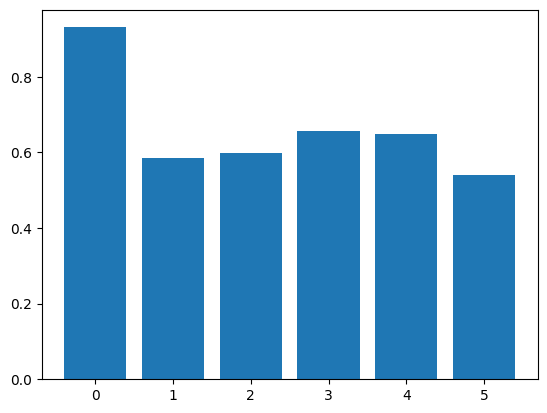

In [42]:
#accuracy bar plot for each category
accuracy = []
for cat in sorted(df["y_true"].round().astype(int).unique()):
    df_cat = df[df["y_true"].round().astype(int) == cat]
    accuracy.append((df_cat["y_true"].round() == df_cat["y_pred"].round()).mean())
plt.bar(sorted(df["y_true"].round().astype(int).unique()), accuracy)

print(accuracy)

In [43]:
from sklearn.metrics import roc_auc_score, root_mean_squared_error, mean_squared_error

Text(0.5, 1.0, 'Mean Squared Error for each week')

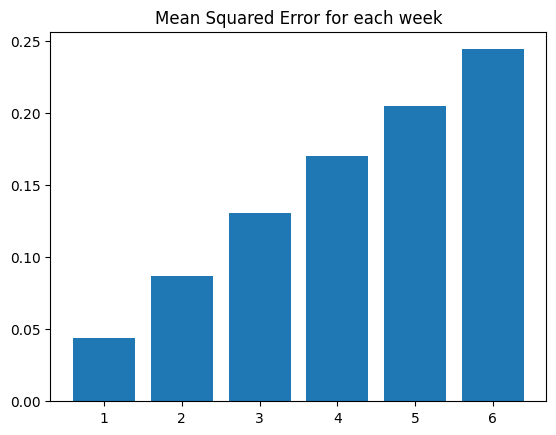

In [44]:
# MAE plot for each week
mse = []
for w in range(6):
    wdf = df[df['week']==w]
    mse.append(mean_squared_error(wdf['y_true'], wdf['y_pred']))
plt.bar(range(1,7), mse)
plt.title("Mean Squared Error for each week")

Text(0.5, 1.0, 'F1 score for each week')

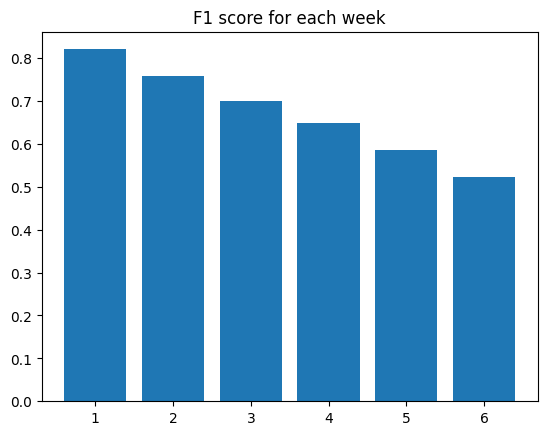

In [45]:
# F1 plot for each week
f1 = []
for w in range(6):
    wdf = df[df['week']==w]
    f1.append(f1_score(wdf['y_true'].round(),wdf['y_pred'].round(), average='macro'))
plt.bar(range(1,7), f1)
plt.title("F1 score for each week")

(array([3.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 2.000e+00, 4.000e+00,
        7.000e+00, 7.000e+00, 1.600e+01, 2.300e+01, 3.800e+01, 4.300e+01,
        4.000e+01, 9.000e+01, 8.700e+01, 1.660e+02, 1.890e+02, 2.390e+02,
        4.240e+02, 1.108e+03, 3.383e+03, 5.792e+03, 1.338e+03, 4.650e+02,
        3.410e+02, 3.170e+02, 2.210e+02, 1.550e+02, 8.900e+01, 5.500e+01,
        3.600e+01, 2.300e+01, 1.400e+01, 1.100e+01, 8.000e+00, 3.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-3.13850927, -2.99286469, -2.84722011, -2.70157552, -2.55593094,
        -2.41028635, -2.26464177, -2.11899719, -1.9733526 , -1.82770802,
        -1.68206343, -1.53641885, -1.39077427, -1.24512968, -1.0994851 ,
        -0.95384051, -0.80819593, -0.66255135, -0.51690676, -0.37126218,
        -0.2256176 , -0.07997301,  0.06567157,  0.21131616,  0.35696074,
         0.50260532,  0.64824991,  0.79389449,  0.93953908,  1.08518366,
         1.23082824,  1.37647283,  1.52211741,  1.667762  ,  1.8

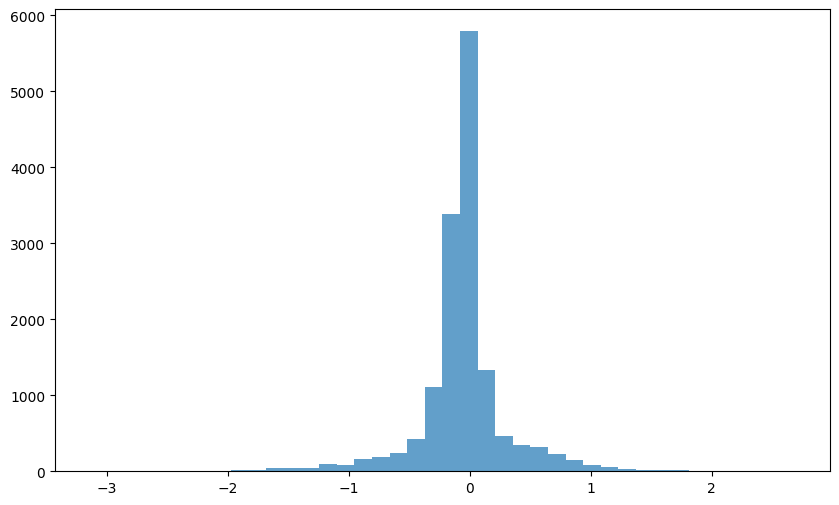

In [46]:
# Error distribution
plt.figure(figsize=(10, 6))
plt.hist(df['y_true'] - df['y_pred'], bins=40, alpha=0.7, label='error')

Text(0, 0.5, 'Residuals')

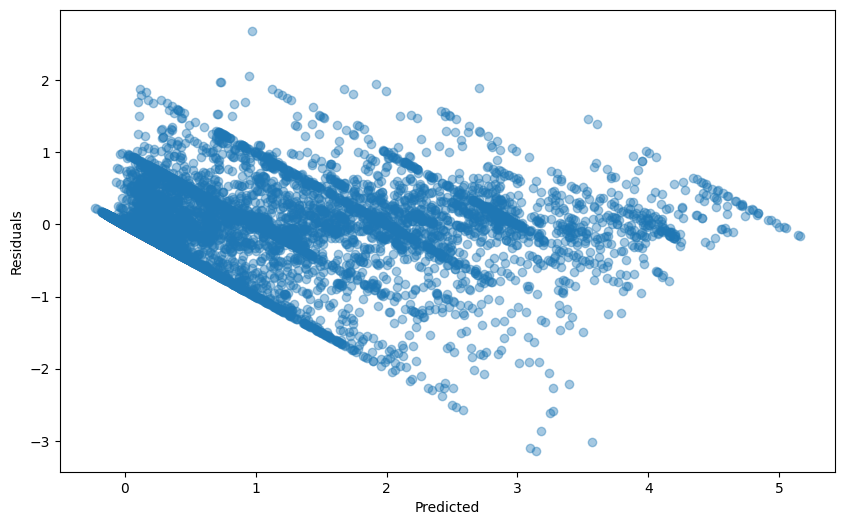

In [47]:
# predicted values vs residuals
plt.figure(figsize=(10, 6))
plt.scatter(df['y_pred'], df['y_true'] - df['y_pred'], alpha=0.4)
plt.xlabel("Predicted")
plt.ylabel("Residuals")

Text(0, 0.5, 'True')

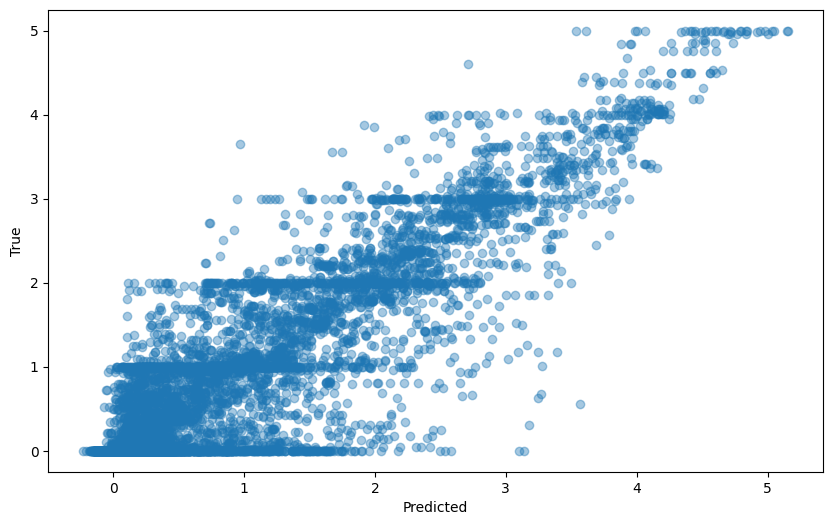

In [48]:
plt.figure(figsize=(10, 6))
plt.scatter(df['y_pred'], df['y_true'], alpha=0.4)
plt.xlabel("Predicted")
plt.ylabel("True")